# L-Layer DNN (Generalized Deep Neural Network)

This notebook implements a generalized L-layer neural network for binary classification, allowing for any number of layers. Below are the key components and equations that define the model.

---

## Data and Activations
- **Data**: Synthetic data with \( X \in \mathbb{R}^{2 \times 400} \) and \( y \in \mathbb{R}^{1 \times 400} \), same as previous models.
- **ReLU Activation**: Used for hidden layers:
  \[
  \text{ReLU}(z) = \max(0, z)
  \]
- **Sigmoid Activation**: Used for the output layer:
  \[
  \sigma(z) = \frac{1}{1 + e^{-z}}
  \]


## Parameter Initialization
For an L-layer network defined by \( \text{layer_dims} = [n_x, n_1, n_2, \dots, n_L] \):
- **Weights**: \( W_l \in \mathbb{R}^{n_l \times n_{l-1}} \), randomly initialized (\( \times 0.01 \)).
- **Biases**: \( b_l \in \mathbb{R}^{n_l \times 1} \), initialized to zeros.
- Example: \( [2, 4, 3, 2, 1] \) for 2 input features, three hidden layers (4, 3, 2 units), and 1 output unit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
X = np.random.randn(2, 400)
y = np.where(X[0, :] + X[1, :] > 0, 1, 0).reshape(1, 400)

In [2]:
# Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

In [3]:
# Initialize parameters
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
    return parameters

## Forward Propagation
For layers \( l = 1 \) to \( L-1 \) (hidden layers):
\[
Z_l = W_l A_{l-1} + b_l, \quad A_l = \text{ReLU}(Z_l)
\]
For the output layer (\( l = L \)):
\[
Z_L = W_L A_{L-1} + b_L, \quad A_L = \sigma(Z_L)
\]
- **\( A_0 = X \)**: Input layer.

In [4]:
# Forward propagation
def forward_propagation_deep(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        Z = np.dot(parameters[f'W{l}'], A_prev) + parameters[f'b{l}']
        A = relu(Z)
        caches.append((A_prev, Z, parameters[f'W{l}'], parameters[f'b{l}']))
    
    ZL = np.dot(parameters[f'W{L}'], A) + parameters[f'b{L}']
    AL = sigmoid(ZL)
    caches.append((A, ZL, parameters[f'W{L}'], parameters[f'b{L}']))
    return AL, caches

## Cost Function
Binary cross-entropy loss:
\[
J = -\frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log(A_L^{(i)}) + (1 - y^{(i)}) \log(1 - A_L^{(i)}) \right]
\]

In [5]:
# Compute cost
def compute_cost_deep(AL, y):
    m = y.shape[1]
    cost = -np.sum(y * np.log(AL) + (1 - y) * np.log(1 - AL)) / m
    return cost

## Backward Propagation
Start at the output layer:
\[
dZ_L = A_L - y
\]
\[
dW_L = \frac{1}{m} dZ_L A_{L-1}^T, \quad db_L = \frac{1}{m} \sum_{i=1}^m dZ_L^{(i)}
\]
For layers \( l = L-1, L-2, \dots, 1 \):
\[
dZ_l = W_{l+1}^T dZ_{l+1} \cdot \text{ReLU}'(Z_l)
\]
\[
dW_l = \frac{1}{m} dZ_l A_{l-1}^T, \quad db_l = \frac{1}{m} \sum_{i=1}^m dZ_l^{(i)}
\]

In [6]:
# Backward propagation
def backward_propagation_deep(X, y, AL, caches):
    grads = {}
    L = len(caches)
    m = X.shape[1]
    
    dZL = AL - y
    A_prev, ZL, WL, bL = caches[L-1]
    grads[f'dW{L}'] = np.dot(dZL, A_prev.T) / m
    grads[f'db{L}'] = np.sum(dZL, axis=1, keepdims=True) / m
    
    for l in range(L-1, 0, -1):
        A_prev, Z, W, b = caches[l-1]
        dZ = np.dot(caches[l][2].T, dZL) * (Z > 0)  # ReLU derivative
        grads[f'dW{l}'] = np.dot(dZ, A_prev.T) / m
        grads[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True) / m
        dZL = dZ
    
    return grads

## Parameter Update
Update the weights and biases for all layers:
\[
W_l = W_l - \alpha dW_l, \quad b_l = b_l - \alpha db_l \quad \text{for } l = 1, 2, \dots, L
\]

In [7]:
# Update parameters
def update_parameters_deep(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        parameters[f'W{l}'] = parameters[f'W{l}'] - learning_rate * grads[f'dW{l}']
        parameters[f'b{l}'] = parameters[f'b{l}'] - learning_rate * grads[f'db{l}']
    return parameters

## Training the Model
The model is trained by iteratively performing forward propagation, computing the cost, performing backward propagation, and updating the parameters for a specified number of epochs.


In [10]:
# Train L-layer DNN
def train_l_layer(X, y, layer_dims, learning_rate=0.01, epochs=3000):
    parameters = initialize_parameters_deep(layer_dims)
    costs = []
    
    for i in range(epochs):
        AL, caches = forward_propagation_deep(X, parameters)
        cost = compute_cost_deep(AL, y)
        grads = backward_propagation_deep(X, y, AL, caches)
        parameters = update_parameters_deep(parameters, grads, learning_rate)
        if i % 100 == 0:
            costs.append(cost)
            print(f"Cost after iteration {i}: {cost}")
    
    return parameters, costs

## Cost Reduction Plot
After training, a plot of the cost over iterations is displayed to visualize the model's learning progress.

Cost after iteration 0: 0.6931471796111535
Cost after iteration 100: 0.6927483956594503
Cost after iteration 200: 0.6925066642579628
Cost after iteration 300: 0.6923601183847502
Cost after iteration 400: 0.6922712662664233
Cost after iteration 500: 0.6922173877983551
Cost after iteration 600: 0.6921847131365273
Cost after iteration 700: 0.6921648956355536
Cost after iteration 800: 0.692152875153834
Cost after iteration 900: 0.6921455835369779
Cost after iteration 1000: 0.6921411602066331
Cost after iteration 1100: 0.6921384767542281
Cost after iteration 1200: 0.6921368487577254
Cost after iteration 1300: 0.6921358610576855
Cost after iteration 1400: 0.6921352618097751
Cost after iteration 1500: 0.6921348982335522
Cost after iteration 1600: 0.6921346776407379
Cost after iteration 1700: 0.6921345437985092
Cost after iteration 1800: 0.6921344625902813
Cost after iteration 1900: 0.6921344133169637
Cost after iteration 2000: 0.6921343834196846
Cost after iteration 2100: 0.6921343652787728
C

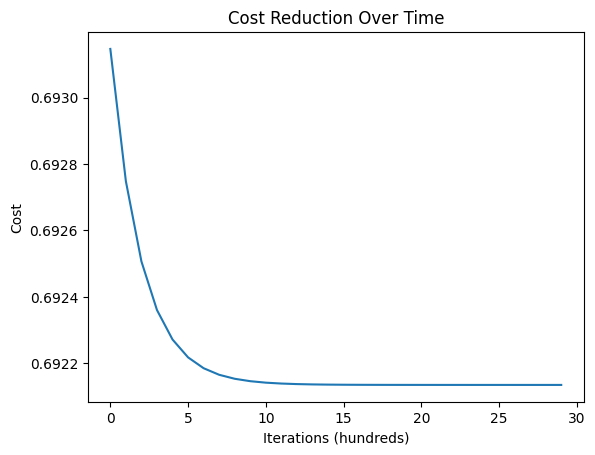

In [11]:
# Run the model
layer_dims = [2, 4, 3, 2, 1]  # Input: 2, Hidden: 4, 3, 2, Output: 1
parameters, costs = train_l_layer(X, y, layer_dims)
plt.plot(costs)
plt.xlabel('Iterations (hundreds)')
plt.ylabel('Cost')
plt.title('Cost Reduction Over Time')
plt.show()